# Drinking age - Bayesian analysis

This example uses the sharp regression discontinuity design to make claims about the causal effects of the minimum legal drinking age (21 in the USA) upon all cause mortality rates. The dataset is from a study by {cite:t}`carpenter2009effect`.

In [1]:
import arviz as az
import matplotlib.pyplot as plt

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

Load and process data.

In [3]:
df = (
    cp.load_data("drinking")
    .rename(columns={"agecell": "age"})
    .assign(treated=lambda df_: df_.age > 21)
)

## Main effects model

First we will examine a simple 'main effects' model. Here, the expected death rate (in units of deaths/1000 people/year) for a given age $a$ (with monthly resolution), is modelled with an intercept term $\beta_0$, a treatment effect $\beta_1$ and an effect of age $\beta_2$.

$$
\mu(a) = \beta_0 + \beta_1 t(a) + \beta_2  a
$$

The term $t(a)$ describes whether 'treatment' has been applied. In this example it simply describes whether a give age $a$ is over the minimum legal drinking age of 21:

$$
\begin{align}
t(a) = 
    \begin{cases} 
        1 & \text{if $a \ge 21$} \\
        0 & \text{if $a < 21$} 
    \end{cases}
\end{align}
$$

To be clear, $\beta_2  a$ describes a linear trend of how expected mortality rate changes with age. The coefficient $\beta_0$ is the intercept of this linear trend (at $a=0$). This leaves $\beta_1 t(a)$ which we can understand as modelling the discontinuity of the linear trend around the age threshold.  

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [4]:
result = cp.RegressionDiscontinuity(
    df,
    formula="all ~ 1 + age + treated",
    running_variable_name="age",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
    treatment_threshold=21,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


For decision-making, you often need a concise summary of the causal effect. The `effect_summary()` method provides a decision-ready report with key statistics. For Regression Discontinuity, the effect is the discontinuity (jump) at the threshold.

In [5]:
stats = result.effect_summary()
stats.table

,mean,median,hdi_lower,hdi_upper,p_gt_0
discontinuity,7.03175,7.013793,4.516501,9.640351,1.0


In [6]:
print(stats.text)

The discontinuity at threshold was 7.03 (95% HDI [4.52, 9.64]), with a posterior probability of an increase of 1.000.


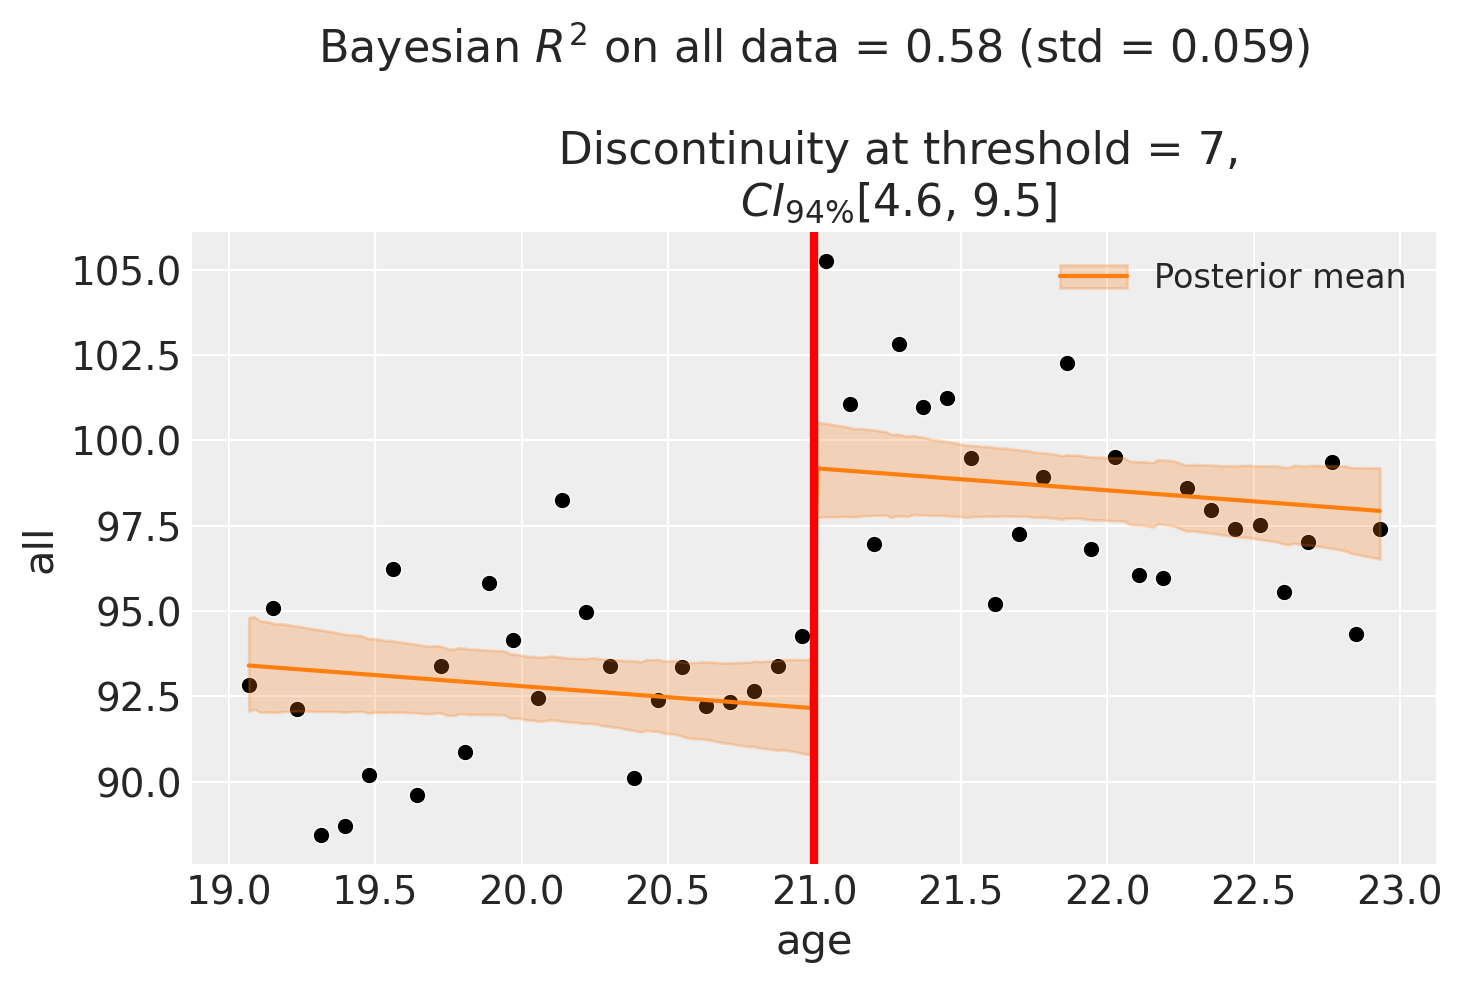

In [7]:
fig, ax = result.plot()

And let's grab the text summary of the results.

In [8]:
result.summary()

Difference in Differences experiment
Formula: all ~ 1 + age + treated
Running variable: age
Threshold on running variable: 21

Results:
Discontinuity at threshold = 7.03$CI_{94\%}$[4.6, 9.5]


Model coefficients:
    Intercept        106, 94% HDI [85, 127]
    treated[T.True]  7, 94% HDI [4.6, 9.5]
    age              -0.65, 94% HDI [-1.7, 0.42]
    y_hat_sigma      2.4, 94% HDI [2, 2.9]


In this main effects model, the size of the causal effect is equal to our posterior estimate of $\beta_1$. Let's plot the parameter estimates (left) and zoom in on the posterior distribution for the main effect of treatment (right).

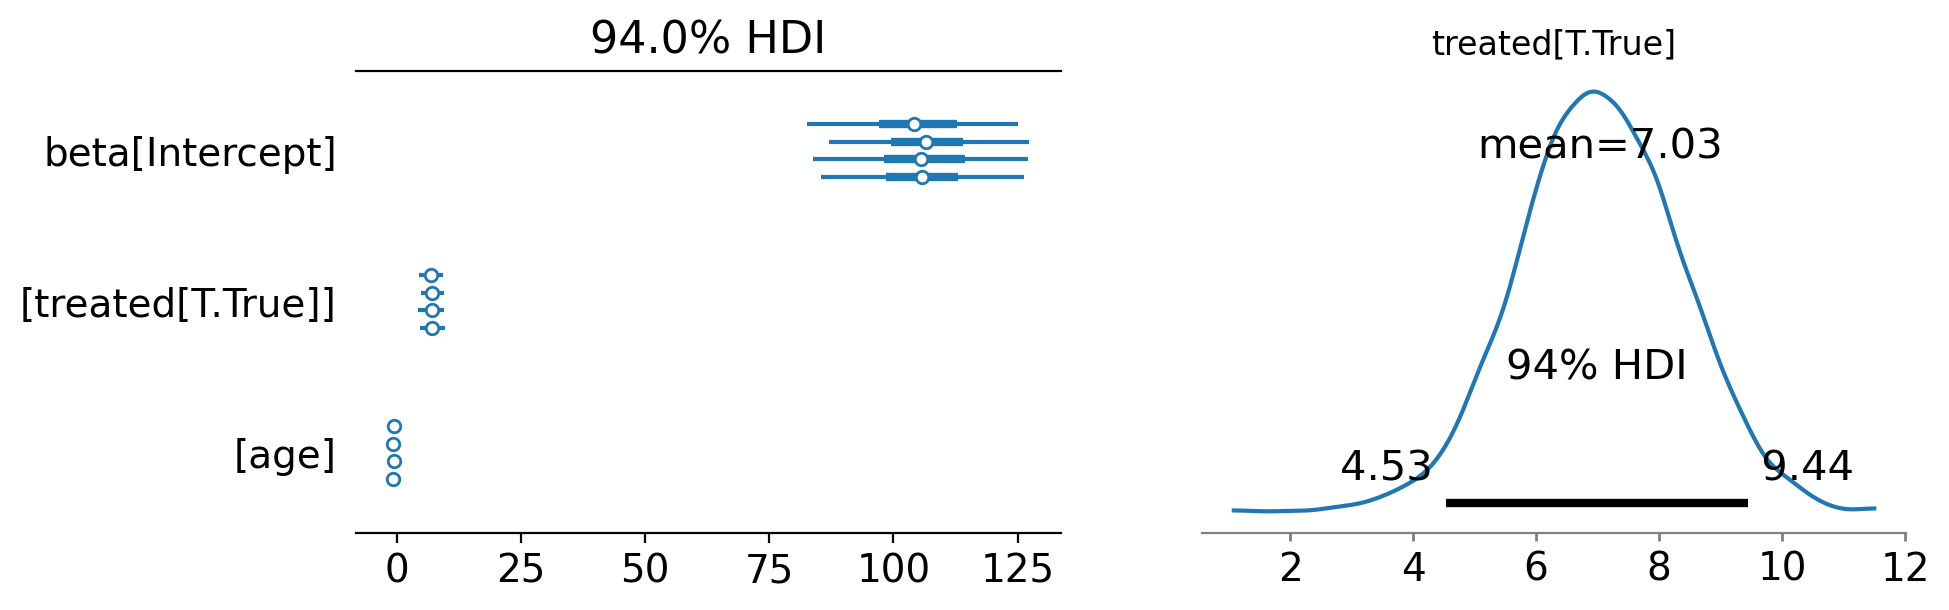

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

az.plot_forest(result.idata.posterior, var_names="beta", ax=ax[0])
az.plot_posterior(
    result.idata.posterior.beta.sel(coeffs="treated[T.True]"),
    round_to=3,
    ax=ax[1],
)

ax[1].set(title="treated[T.True]")
fig

We can see that this matches up (nearly exactly) with the "discontinuity at threshold" figures in the first results figure.

It is not exactly the same because we actually manually calculate the discontinuity at threshold. The reason for this is because in anything but the simplest model, the discontinuity at threshold is not simply equal to this parameter. In order to understand this, let's look at the marginally more complex model where we incorporate an interaction term.

## Interaction model

We add an interaction term by changing our formula to `all ~ 1 + age + treated + age:treated`. This now changes the statistical model to :

$$
\mu(a) = \beta_0 + \beta_1 t(a) + \beta_2  a + \beta_3 t(a) \cdot a
$$

This model is now more complex in that it can _allow_ for the trend in mortality rate to vary before versus after the age of 21 _if the data suggest it_. If it is not clear already, it will be clear from the next results figure that the discrepancy at threshold is no longer equal to the $\beta_1$ coefficient. Let's run the model and see.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


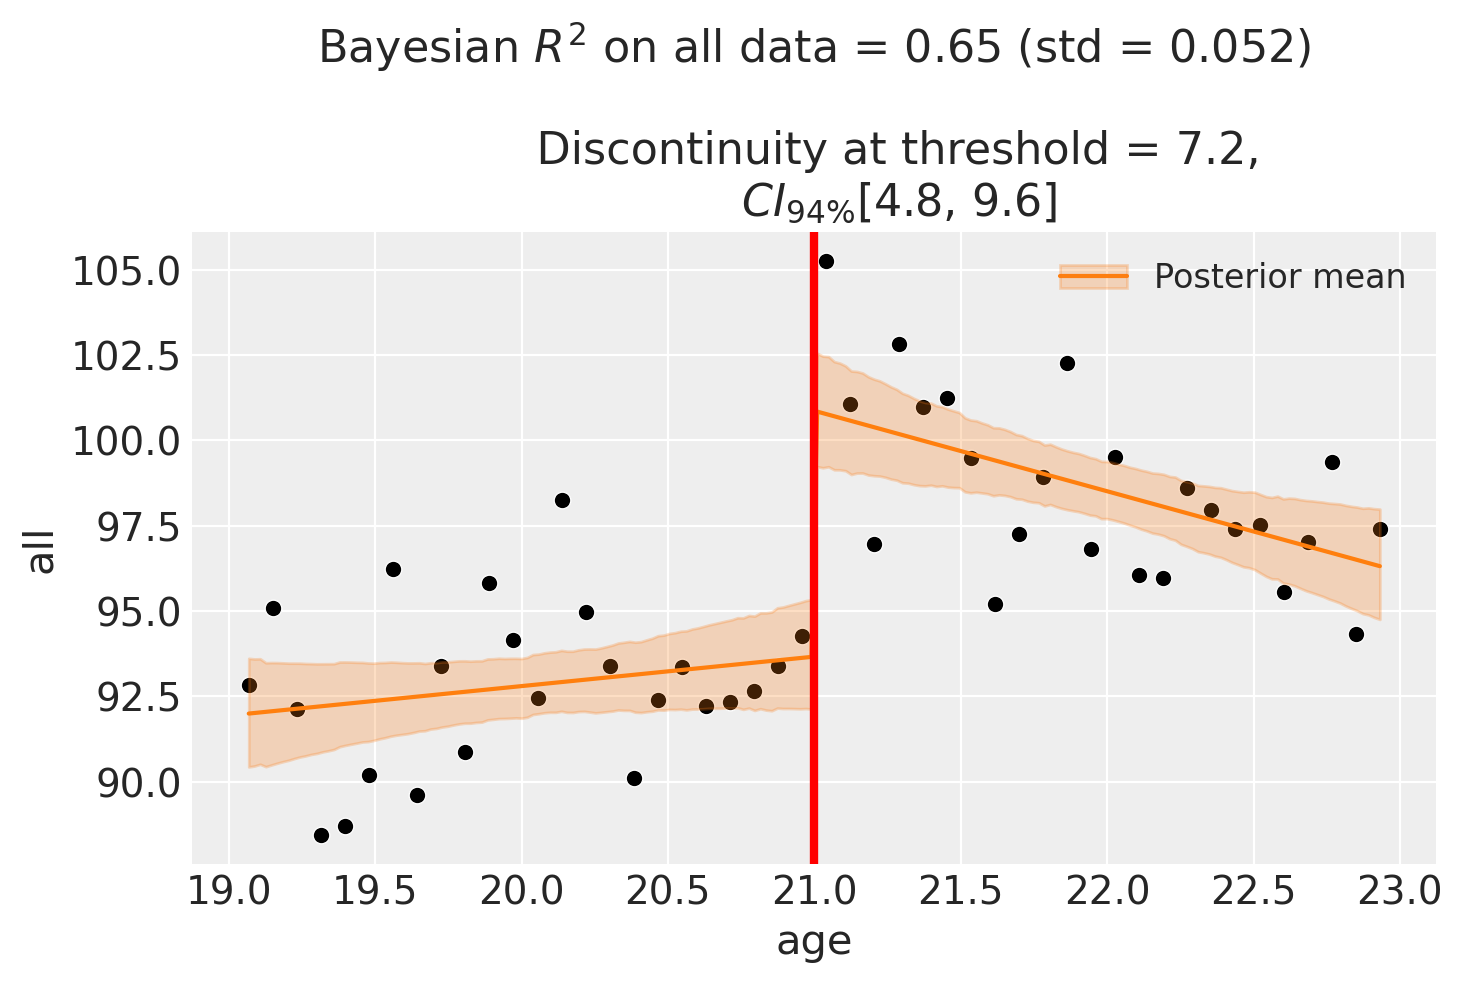

In [10]:
result2 = cp.RegressionDiscontinuity(
    df,
    formula="all ~ 1 + age + treated + age:treated",
    running_variable_name="age",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=21,
)

fig, ax = result2.plot()
fig

We can now see that by adding an interaction term, the parameter estimates are now much changed, and the estimated discontinuity at threshold is no longer simply given by the $\beta_1$ parameter. To confirm this, we can check the estimate of $\beta_1$ (which corresponds to the `treated[T.True]` coefficient).

In [11]:
az.plot_forest(result2.idata.posterior, var_names="beta", figsize=(10, 3))

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

We can see that this estimate is now wildly off the desired "discontinuity at threshold" value. It is for this reason that `CausalPy` manually calculates the "discontinuity at threshold" by evaluating the difference in predicted outcome values slightly above versus slightly below the treatment threshold.

We can get a decision-ready summary of the causal effect for this interaction model:


In [12]:
stats2 = result2.effect_summary()
stats2.table

,mean,median,hdi_lower,hdi_upper,p_gt_0
discontinuity,7.20073,7.228019,4.768886,9.732512,1.0


## Centering the running variable on the treatment threshold

Another practice to deal with this is to centre the running variable on the threhsold such that the threshold (minimum legal drinking age) is now at zero. This also makes the parameters more interpretable.

In [13]:
df["age"] = df["age"] - 21

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


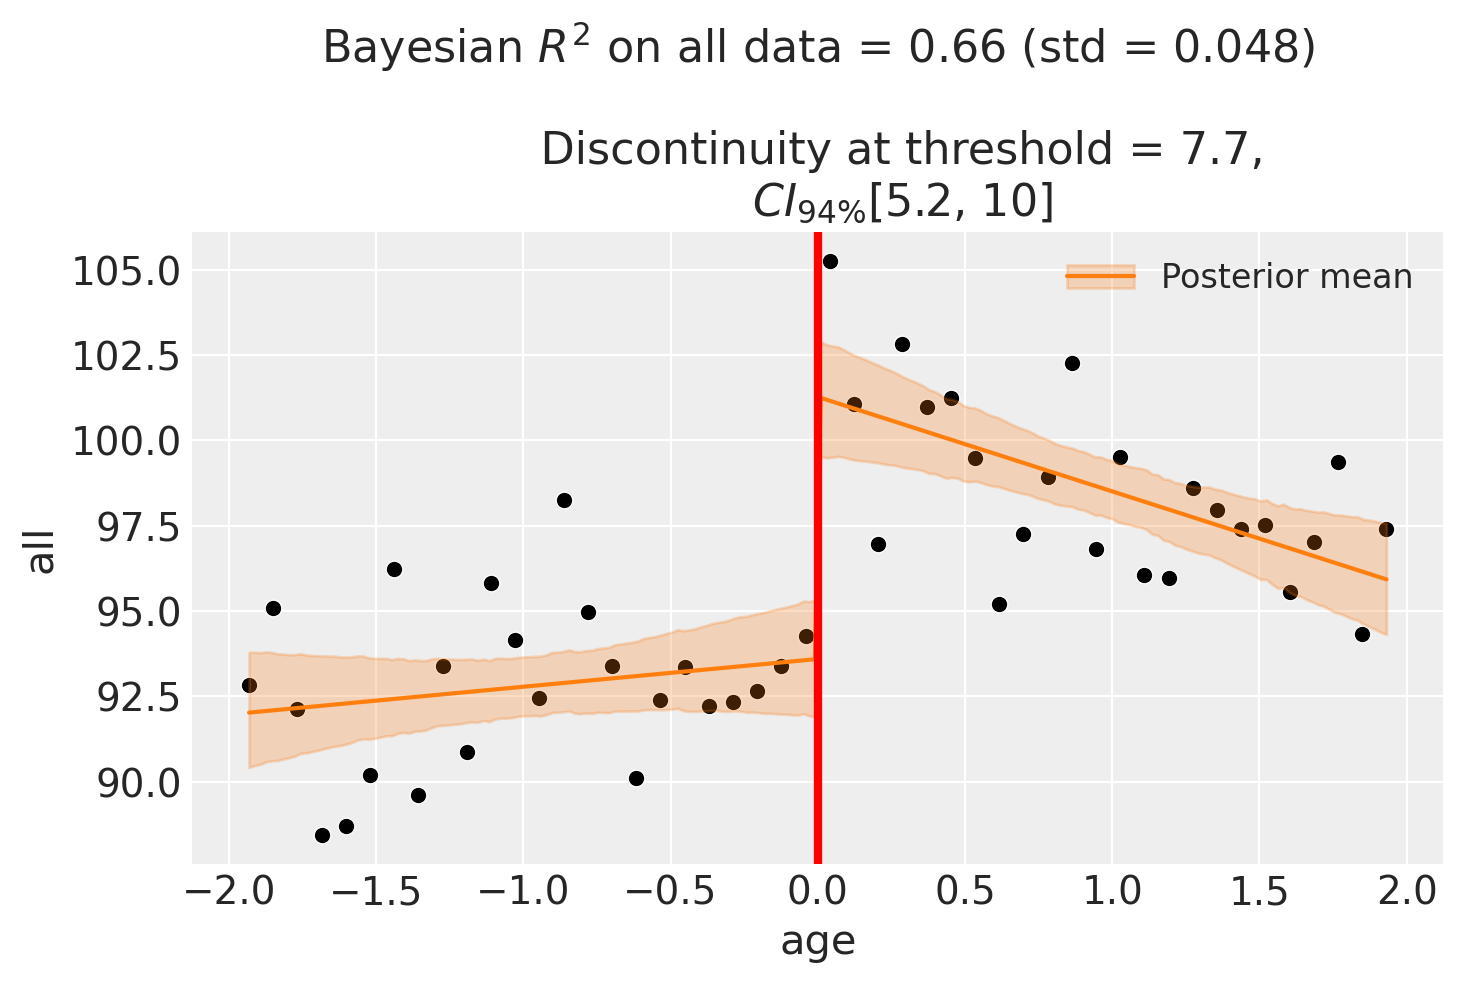

In [14]:
result3 = cp.RegressionDiscontinuity(
    df,
    formula="all ~ 1 + age + treated + age:treated",
    running_variable_name="age",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0,
)

fig, ax = result3.plot()
fig

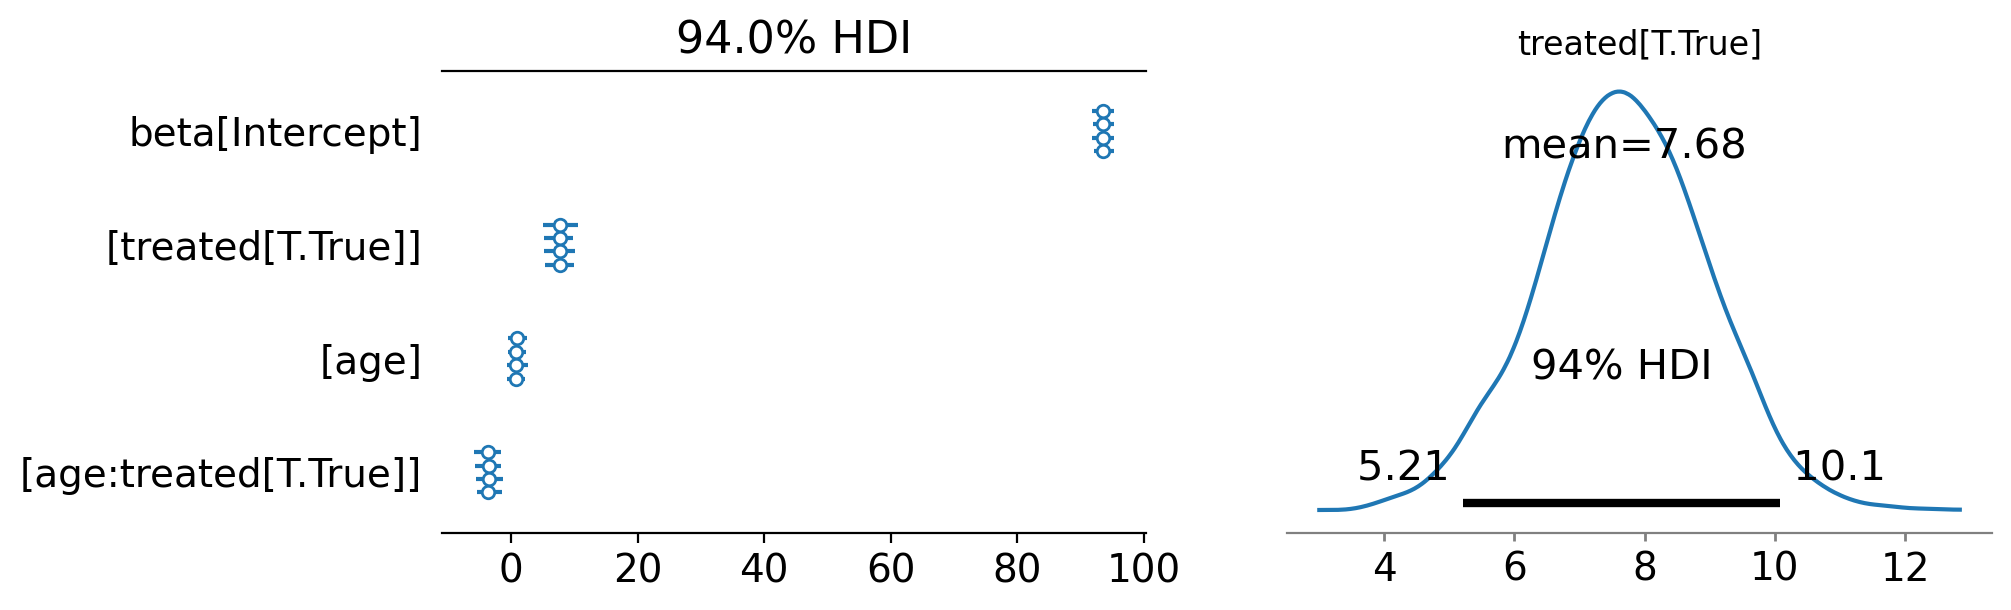

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

az.plot_forest(result3.idata.posterior, var_names="beta", ax=ax[0])
az.plot_posterior(
    result3.idata.posterior.beta.sel(coeffs="treated[T.True]"),
    round_to=3,
    ax=ax[1],
)

ax[1].set(title="treated[T.True]")
fig

And the effect summary for the centered model:


In [16]:
stats3 = result3.effect_summary()
stats3.table

,mean,median,hdi_lower,hdi_upper,p_gt_0
discontinuity,7.6771,7.677621,5.168516,10.28312,1.0


## References
:::{bibliography}
:filter: docname in docnames
:::